In [62]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import os

import numpy as np
from numpy import nanmean, nanstd

In [63]:
ccfrp_dates = ['20250627', '20250702', '20250703']

In [64]:
# Thinking about fish morphology (rockfish have same total length as fork length)

In [65]:



def rock_fish_adjustment(df):
    """
    Adjusts the GT Total Length for rockfish species by setting it equal to GT Fork Length.
    """
    rockfish_species = ['Black Rockfish', 'Blue Rockfish', 'China Rockfish', 'Copper Rockfish', 'Deacon Rockfish',
                        'Gopher Rockfish', 'Grass Rockfish', 'Olive Rockfish', 'Quillback Rockfish',
                        'Redbanded Rockfish', 'Rosy Rockfish', 'Tiger Rockfish', 'Brown Rockfish', 'Longfin Sanddab', 'Vermilion Rockfish',]
    
    for row in df.itertuples():
        if row._7 in rockfish_species:
            if str(row._8) == 'nan':
                df.at[row.Index, 'GT Total Length'] = row._9  # Set GT Total Length equal to GT Fork Length
            elif str(row._9) == 'nan':
                df.at[row.Index, 'GT Fork Length'] = row._8  # Set GT Fork Length equal to GT Total Length
            else:
                continue
        
    return df

In [66]:
# ccfrp_fsm_df = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - fish_length_prediction_filtered_date.csv')

# ccfrp_dfs = []
# for date in ccfrp_dates:
#     df = pd.read_csv(f'/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - {date}.csv')
#     df['date'] = date
#     ccfrp_dfs.append(df)

# ccfrp_results = pd.concat(ccfrp_dfs)

ccfrp_results = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - fish_length_prediction_filtered_date_v5.csv')
ccfrp_results = rock_fish_adjustment(ccfrp_results)
ccfrp_results = ccfrp_results.query('timestamp_pst_date == "2025-07-01"')

lab_results = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - 20250701.csv')

ccfrp_results = ccfrp_results[['Common Name', 'TagID', 'Device', 'GT Total Length', 'GT Fork Length', 'Predicted Length', 'confidence']]

ccfrp_results['Tech'] = 'FSM'
ccfrp_results['Device'] = ('Ipad' if ccfrp_results['Device'].str == 'iPad' else ccfrp_results['Device'])
ccfrp_results['Device'] = ('Phone' if ccfrp_results['Device'].str == 'iPhone' else ccfrp_results['Device'])

ccfrp_results

,Common Name,TagID,Device,GT Total Length,GT Fork Length,Predicted Length,confidence,Tech
23,Vermilion Rockfish,30284.0,iPad,277.0,275.0,278.587522,2,FSM
24,Vermilion Rockfish,30284.0,iPad,277.0,275.0,282.362698,2,FSM
25,Vermilion Rockfish,30284.0,iPad,277.0,275.0,280.919579,2,FSM
26,Vermilion Rockfish,30284.0,iPad,277.0,275.0,279.176455,1,FSM
27,Vermilion Rockfish,30284.0,iPad,277.0,275.0,281.852984,1,FSM
...,...,...,...,...,...,...,...,...
327,Calico Rockfish,30293.0,iPhone,149.0,147.0,153.646902,2,FSM
328,Calico Rockfish,30293.0,iPhone,149.0,147.0,152.472163,2,FSM
329,Calico Rockfish,30293.0,iPhone,149.0,147.0,154.064664,2,FSM
330,Calico Rockfish,30293.0,iPhone,149.0,147.0,156.926849,2,FSM


In [67]:
# preprocessing
lab_df = pd.melt(lab_results,
    id_vars=['Common Name', 'TagID', 'GT Total Length', 'GT Fork Length'],
    value_vars=['FSM Phone', 'FSM Ipad', 'FT Phone', 'FT Ipad'],
    value_name='Predicted Length'
).reset_index()

lab_df[['Tech', 'Device']] = lab_df['variable'].str.split(' ', expand=True)

lab_df.drop(columns=['variable'], inplace=True)


lab_df.drop(columns=['index'], inplace=True)

lab_df = lab_df.query('Tech != "FSM"')

lab_df = pd.concat([lab_df, ccfrp_results], ignore_index=True)


lab_df['GT Length'] = lab_df['GT Total Length'] if (lab_df['Tech'].str == 'FT') else lab_df['GT Fork Length']

lab_df['Residual'] = abs(lab_df['GT Length'] - lab_df['Predicted Length'])
lab_df['Percent Error'] = (lab_df['Residual'] / lab_df['GT Length']) * 100

In [68]:
from numpy import mean


ccfrp_df = pd.read_csv('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/data/fishsense_output - fish_length_prediction_filtered_date_v5.csv').query('timestamp_pst_date != "2025-07-01" and `Common Name` != "George"')

ccfrp_df = rock_fish_adjustment(ccfrp_df)

ccfrp_df['Residual'] = abs(ccfrp_df['GT Fork Length'] - ccfrp_df['Predicted Length'])
ccfrp_df['Percent Error'] = (ccfrp_df['Residual'] / ccfrp_df['GT Fork Length']) * 100



### Theo's plot ideas

In [69]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [70]:
plot_df = ccfrp_df.query('confidence > .5')


# Optionally turn off Seaborn's styling

# plt.style.use('seaborn-v0_8-talk')

sns.set_theme(style="white", rc={'figure.figsize':(4,3)})

7.010941387533499
5.0182971492784265


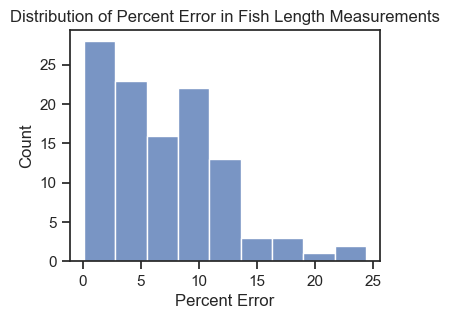

In [71]:
# X axis: Residual of measurement in consideration to the ground truth data. Y axis: count of photos



fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.histplot(data=plot_df, x='Percent Error')

plt.xlabel('Percent Error')
plt.ylabel('Count')
plt.title('Distribution of Percent Error in Fish Length Measurements')

print(nanmean(plot_df['Percent Error']))
print(nanstd(plot_df['Percent Error']))

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_all_dist.pdf', bbox_inches='tight')

Text(0.5, 0, 'Confidence')

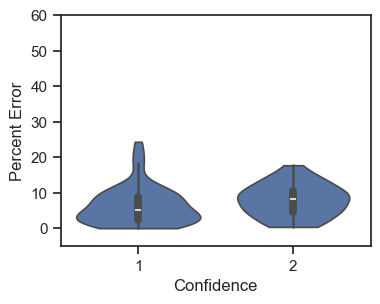

In [72]:
# margin error vs confidence

fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
sns.violinplot(data=plot_df, x='confidence', y='Percent Error', cut=0)
plt.ylim(-5,60)
plt.xlabel('Confidence')


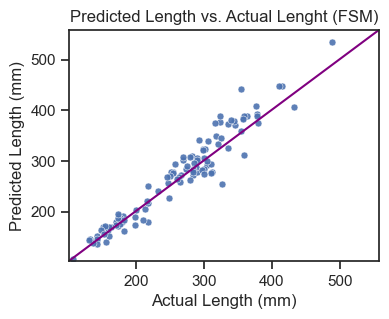

In [73]:

import numpy as np
# X axis: Ground truth. Y axis: measurement in consideration. Plot y=x line. Points show how far away our data in consideration is from the ground truth. Just FSM.

plot_df = ccfrp_df.query('confidence > .5')


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.scatterplot(data=plot_df, x='GT Fork Length', y='Predicted Length', alpha=.9, s=25)

x_line = np.linspace(0, np.max(ccfrp_df['GT Fork Length'] + 20), 100)
y_line = x_line + 1
plt.plot(x_line, y_line, color='purple')

plt.xlabel('Actual Length (mm)')
plt.ylabel('Predicted Length (mm)')
plt.title('Predicted Length vs. Actual Lenght (FSM)')
plt.xlim(np.min(ccfrp_df['GT Fork Length']), np.max(ccfrp_df['GT Fork Length'] + 20))
plt.ylim(np.min(ccfrp_df['GT Fork Length']), np.max(ccfrp_df['GT Fork Length'] + 20))

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_all_scatter.pdf', bbox_inches='tight')

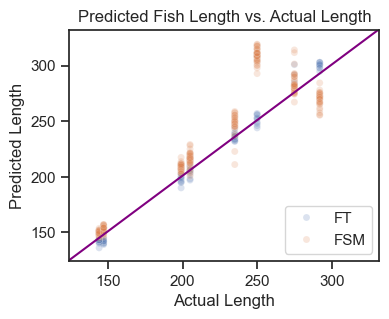

In [74]:
import numpy as np
# X axis: Ground truth. Y axis: measurement in consideration. Plot y=x line. Points show how far away our data in consideration is from the ground truth. Factored for Fishsense vs Fishtechy


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.scatterplot(data=lab_df, x='GT Length', y='Predicted Length', hue='Tech', alpha=0.2, s=25)

x_line = np.linspace(0, max(lab_df['GT Total Length']) + 100, 100)
y_line = x_line + 1
plt.plot(x_line, y_line, color='purple')
plt.xlim(min(lab_df['GT Total Length'])-20, max(lab_df['GT Total Length']) + 40)
plt.ylim(min(lab_df['GT Total Length'])-20, max(lab_df['GT Total Length']) + 40)
plt.legend(frameon=True, loc='lower right')
plt.xlabel("Actual Length")
plt.title("Predicted Fish Length vs. Actual Length")

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_ft_scatter.pdf', bbox_inches='tight')

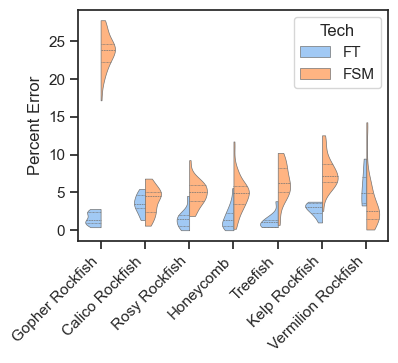

In [75]:
# violin plot fsm vs ft


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.violinplot(data=lab_df, y='Percent Error', x='Common Name', hue='Tech', split=True, inner='quartile', cut=0, linewidth=0.5,                # thinner lines like Matplotlib                # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1)
plt.xticks(rotation=45, ha='right')
plt.xlabel(None)

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_ft_species_error.pdf')

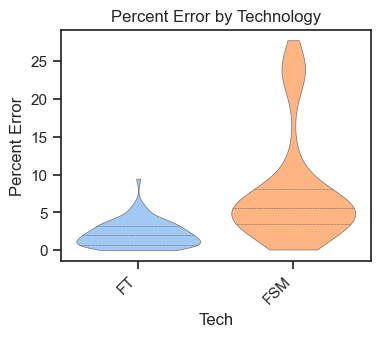

In [76]:
# violin plot for ft vs fsm


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
sns.violinplot(data=lab_df, y='Percent Error', x='Tech', hue='Tech', cut=0, linewidth=0.5,                # thinner lines like Matplotlib
    inner='quartile',                 # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Percent Error')
plt.title('Percent Error by Technology')

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/fsm_ft_error.pdf')

In [77]:
plot_df

,timestamp,timestamp_pst_time,timestamp_pst_date,Device,Predicted Length,TagID,Common Name,GT Fork Length,GT Total Length,confidence,Residual,Unnamed: 11,Percent Error
0,1751040799,9:13:19,2025-06-27,iPad,348.721283,NaN,NaN,NaN,NaN,1,NaN,348.721283,NaN
4,1751050086,11:48:06,2025-06-27,iPad,375.794459,29294.0,Brown Rockfish,324.0,NaN,2,51.794459,375.794459,15.985944
5,1751050103,11:48:23,2025-06-27,iPad,384.971235,29211.0,Brown Rockfish,358.0,NaN,2,26.971235,384.971235,7.533865
6,1751057767,13:56:07,2025-06-27,iPad,534.081401,29272.0,California Sheephead,489.0,506.0,2,45.081401,534.081401,9.219100
10,1751059022,14:17:02,2025-06-27,iPad,306.263308,29244.0,California Sheephead,300.0,305.0,1,6.263308,306.263308,2.087769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1751568145,11:42:25,2025-07-03,iPhone,281.250160,29385.0,Vermilion Rockfish,284.0,NaN,1,2.749840,281.250160,0.968253
519,1751568159,11:42:39,2025-07-03,iPhone,277.338291,29385.0,Vermilion Rockfish,284.0,NaN,1,6.661709,277.338291,2.345672
520,1751568456,11:47:36,2025-07-03,iPhone,299.821857,29390.0,Kelp Rockfish,304.0,NaN,1,4.178143,299.821857,1.374389
521,1751568515,11:48:35,2025-07-03,iPhone,263.275062,29391.0,Gopher Rockfish,261.0,NaN,1,2.275062,263.275062,0.871671


/var/folders/2b/d0h5v9t55gg2wl7c9csv2x280000gn/T/ipykernel_63756/3619770854.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=top_df, y='Percent Error', x='Common Name', cut=0, linewidth=0.5,                # thinner lines like Matplotlib


3.8112717323328997


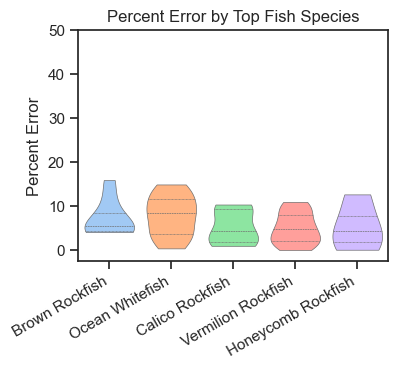

In [78]:

# violin plot for different species only fsm
plot_df.value_counts('Common Name')

top_df = plot_df.query('confidence > 0.5 and `Common Name` in ["Ocean Whitefish", "Vermilion Rockfish", "Calico Rockfish", "Honeycomb Rockfish", "Brown Rockfish"]')

fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)

sns.violinplot(data=top_df, y='Percent Error', x='Common Name', cut=0, linewidth=0.5,                # thinner lines like Matplotlib
    inner='quartile',                 # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1)


plt.xticks(rotation=30, ha='right')
plt.ylabel('Percent Error')
plt.title('Percent Error by Top Fish Species')
plt.xlabel(None)
plt.ylim(-2.5, 50)

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/top_species_error.pdf', bbox_inches='tight')

print(plot_df.groupby('Common Name')['Percent Error'].agg('mean').std(skipna=True))

In [79]:
plot_df

,timestamp,timestamp_pst_time,timestamp_pst_date,Device,Predicted Length,TagID,Common Name,GT Fork Length,GT Total Length,confidence,Residual,Unnamed: 11,Percent Error
0,1751040799,9:13:19,2025-06-27,iPad,348.721283,NaN,NaN,NaN,NaN,1,NaN,348.721283,NaN
4,1751050086,11:48:06,2025-06-27,iPad,375.794459,29294.0,Brown Rockfish,324.0,NaN,2,51.794459,375.794459,15.985944
5,1751050103,11:48:23,2025-06-27,iPad,384.971235,29211.0,Brown Rockfish,358.0,NaN,2,26.971235,384.971235,7.533865
6,1751057767,13:56:07,2025-06-27,iPad,534.081401,29272.0,California Sheephead,489.0,506.0,2,45.081401,534.081401,9.219100
10,1751059022,14:17:02,2025-06-27,iPad,306.263308,29244.0,California Sheephead,300.0,305.0,1,6.263308,306.263308,2.087769
...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,1751568145,11:42:25,2025-07-03,iPhone,281.250160,29385.0,Vermilion Rockfish,284.0,NaN,1,2.749840,281.250160,0.968253
519,1751568159,11:42:39,2025-07-03,iPhone,277.338291,29385.0,Vermilion Rockfish,284.0,NaN,1,6.661709,277.338291,2.345672
520,1751568456,11:47:36,2025-07-03,iPhone,299.821857,29390.0,Kelp Rockfish,304.0,NaN,1,4.178143,299.821857,1.374389
521,1751568515,11:48:35,2025-07-03,iPhone,263.275062,29391.0,Gopher Rockfish,261.0,NaN,1,2.275062,263.275062,0.871671


Device
iPad      6.982271
iPhone    7.033600
Name: Percent Error, dtype: float64

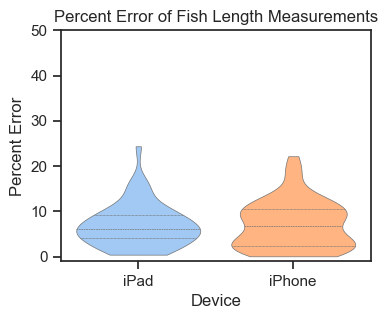

In [80]:
# violin plot for different devices only fsm


fig, ax = plt.subplots()
ax.tick_params(bottom=True, left=True)
sns.violinplot(data=plot_df, y='Percent Error', x='Device', hue='Device', cut=0, linewidth=.5,                # thinner lines like Matplotlib
    inner='quartile',                 # remove inner box/points if not needed
    palette="pastel",           # use a Matplotlib-like pastel palette
    saturation=1)
plt.ylabel('Percent Error')
plt.title('Percent Error of Fish Length Measurements')
plt.ylim(-1, 50)

plt.savefig('/Users/anu/Documents/e4e/2025-07-21_fishsense-mobile-data-processing/plots/device_error.pdf')

plot_df.groupby('Device')['Percent Error'].mean()

In [81]:
nanmean(plot_df['Percent Error'])

7.010941387533499